# Проект Danss
В данном проекте определяются поправки к зависимости осциляций нетрино от пройденого пути вызваные не точечностью источника частиц и детектора.



## Задача
Определить распределение электроного и мюоного нейтрино в детекторе расположеного возле реактора.


## Геометрия задачи
Рассмотрим следующию модель:реактор - цилиндр с высотой H и радиусом R

*   реактор - цилиндр с высотой $H$ и радиусом $R$
*   детектор - куб с длиной ребра $a$
*   Взаимное расположение: куб и цилиндр стоят на одной плоскости. $L$ - растояие между центрами фигур, $\theta$ - угол поворота куба в этой плоскости
(т.е. угл между прямой соединяющей центры фигур и нормалью грани)

Если мы будим использовать декардовы координаты от центра основания для точки из детектора ($x, y, z$) и цилиндрические координаты для точки из реактора ($h, r, \varphi$), то растояние между точкой из реактора и точкой из детектора будет:

$ l=\sqrt{(L-r\cos \varphi -y\cos θ +x\sin θ)^2 + (r\sin \varphi +y\sin θ +x\cos θ)^2 +(z-h)^2}$

Распределение растояний будет тогда:

$$ F(l) = \frac{\int_{l(...)=l}{dxdydzdhdrdφ}}{\int{dxdydzdhdrdφ}}=\frac{1}{\pi R^2Ha^3}\int_{l(...)=l}{dxdydzdhdrdφ}$$

Как видно, в явном виде посчитать этот интеграл не представляется возможным.

Для нахождения F(l) сделаем численый расчёт.

В эксперименте на Калининской АЭС геометрические параметры следующие:

$a=1\ \text{м},\ R=2\ \text{м},\ H=2\ \text{м},\ L=9-11\ \text{м}$

## Численый метод определения распределения
Код находится в "main.cpp"

### Метод прямого перебора

В методе прямого перебора мы создаём регулярную сетку точек в объёмах куба и цилиндра с неким шагом.

Главный недостаток даного метода связан с длительностью исполнения вложеных циклов при достаточно малого шага сетки (число пар растёт как $(\frac{\text{размеры тел}}{ϵ})^6 \sim 10^{3*6}$).

### Метод Монте-Карло
Для ускорения расчёта мы можем генерировать две случайые точки с равномерным распределением в объёмах детектора и реактора, а потом определять растоянием между ними. Таким образом мы пролучаем репрезентативную выборотку пар точек и соотвествующих длин.
Даный метод работает быстрее потому что достаточно сгенерировать выборотку длиной примерно $10^6$

Один из главных моментов в методе является правильный выбор распределения вероятностей в ГПСЧ. Наша цель сделать равномерно по объёму, т.е. т.е. для любого интегрирования плотности в. по равновеликим фигурам даёт одно и тоже значение вероятности.
Есть два варианта (по x,y,z,h вопросов нет):
*   равномерно по $φ$ и $r$, тогда в центре "плотнее"
*   равномерно по $φ$ и $\frac{r^2}{2}$ (так как $ds=rdr d\varphi$)

При втором варианте достигается требуемый вариант.


### Отрисовка распределения
Воспользуемся пакетами matplotlib

In [1]:
import numpy as np
#Рисование (Импорт)
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [2]:
#Получение данных гистограммы

data=[]
with open('Data_mont', 'r') as file:
    arr=file.readlines()
    for line in arr[9:]:
        data.append(int(line))
    # arrx, arrx, arrz = arr[1].split()
    # H = float(arrz)
    # arrx, arrx, arrz = arr[2].split()
    # R = float(arrz)
    # arrx, arrx, arrz = arr[3].split()
    # a = float(arrz)
    # arrx, arrx, arrz = arr[4].split()
    # L = float(arrz)
    # arrx, arrx, arrz = arr[5].split()
    # theta = float(arrz)
    arrx, arrx, arrx, arry, arrz = arr[6].split()
    x_max = float(arry)
    x_min = float(arrz)
    arrx, arrx, arrz = arr[7].split()
    err = float(arrz)

# data = np.loadtxt('Data_end', skiprows = 1)
# x_min =
# err =

In [3]:
#Обработка (добавление длин)
l=[]
for i in range(len(data)):
    l.append(x_min+ i*err)

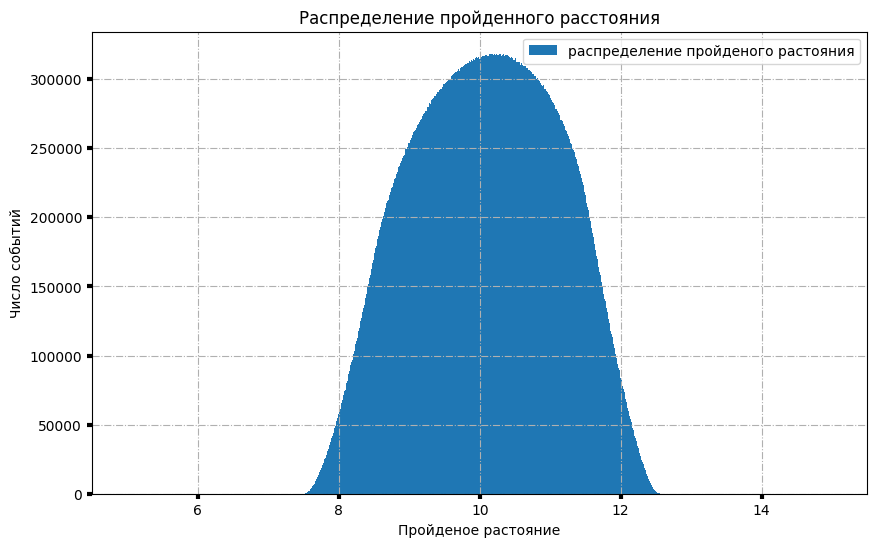

In [4]:
#Рисование гистограммы и другое
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Распределение пройденного расстояния')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)

ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")

ax.legend()
pyplot.show()

## Фитирование распределения $F(l)$

Воспользуемся пакетами scipy.optimize для фитирования полученной гистограммы.

### Поиск пробной функции

In [5]:
#Фитирование (библиотеки)
from scipy.optimize import curve_fit
from scipy.special import  erf
from math import exp

In [6]:
# Границы фитирования
flag = 0;
for i in range(len(data)):
  if flag == 0 and data[i]>0:
    i_min = i
    flag = 1
  if flag == 1 and data[i] ==0:
    i_max=i
    break

In [7]:
#Пробная функция - квадратичная
def parab(x, a, b, c):
    return c-a*np.power(np.abs(x-b), 2)
args_p, covar_p = curve_fit(parab, l[i_min+100:i_max-100], data[i_min+100:i_max-100], [1.,10.0, 400.0])
perr = np.sqrt(np.diag(covar_p))
args_p, perr

(array([5.32367837e+04, 1.01367907e+01, 3.20550037e+05]),
 array([3.46594029e+02, 2.68015978e-03, 3.81261353e+02]))

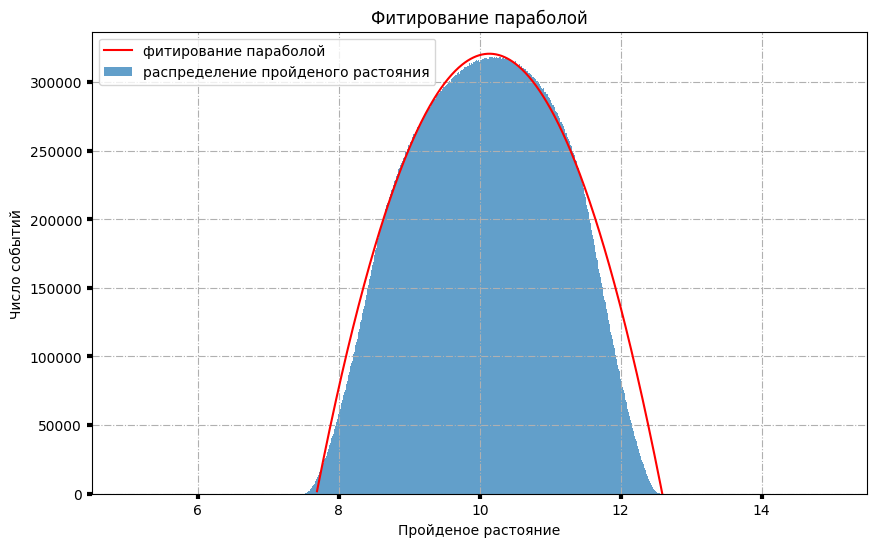

In [8]:
x = []
y = []
for i in range(len(l)):
    if parab(l[i], args_p[0], args_p[1], args_p[2]) > 0:
      x.append(l[i])
      y.append(parab(l[i], args_p[0], args_p[1], args_p[2]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование параболой')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)

ax.bar(l, data, linewidth = 1., width = err, alpha = 0.7, label = "распределение пройденого растояния")
ax.plot(x, y, color='r', label = "фитирование параболой")
ax.legend()
pyplot.show()

In [9]:
#Фитирование гаусовым пиком
def gauss(x, a, b, c, d):
    return a*np.exp(-(x-b)**2 /c)+d
args, covar = curve_fit(gauss, l[i_min:i_max], data[i_min:i_max], [300000.0,11.0, 100.0,0.0])
perr = np.sqrt(np.diag(covar))
args, perr

(array([-4.40809055e+09,  1.00788519e+01, -7.78368689e+04,  4.40840980e+09]),
 array([5.33400342e+10, 3.90070966e-03, 9.41828703e+05, 5.33400344e+10]))

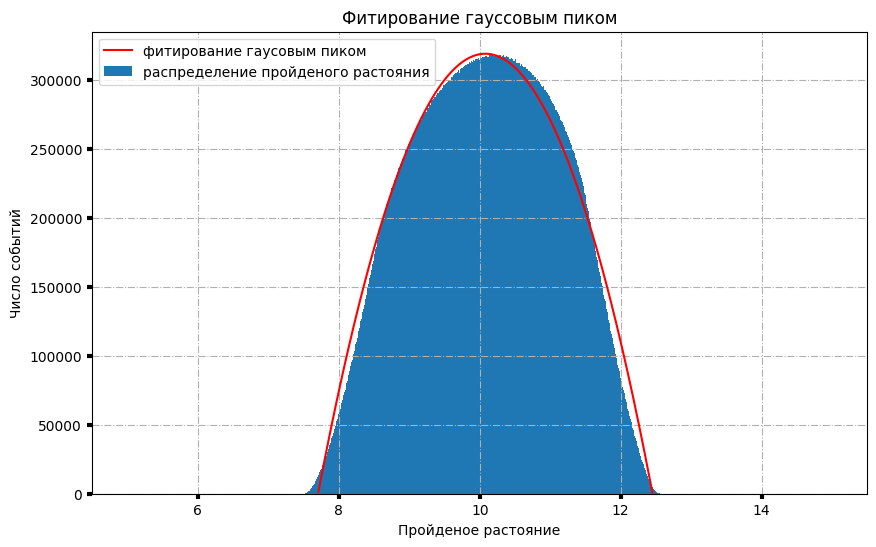

In [10]:
xx = []
yy = []
for i in range(i_min, i_max):
    if gauss(l[i], args[0], args[1], args[2], args[3]) > 0:
      xx.append(l[i])
      yy.append(gauss(l[i], args[0], args[1], args[2], args[3]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование гауссовым пиком')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)


ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")
ax.plot(xx, yy, color='r', label = "фитирование гаусовым пиком")
ax.legend()
pyplot.show()

In [11]:
#Фитирование гаусовым пиком
def gauss_as(x, a, b, c, d, f):
    return a* np.exp(-(x-b)**2/c)*(1+erf(f*x))+d
    # a*np.exp(-(x-b)**2 /c1)+d
args, covar = curve_fit(gauss_as, l[i_min:i_max], data[i_min:i_max], [300000.0,11.0, 100.0,0.0, -0.01])
perr = np.sqrt(np.diag(covar))
args, perr

(array([-1.58466682e+11,  1.01191043e+01, -5.23740403e+06,  3.16933687e+11,
         4.72328561e-01]),
 array([2.30873477e+10, 3.78767467e-03, 7.63294291e+05, 4.61746953e+10,
        2.78549712e-03]))

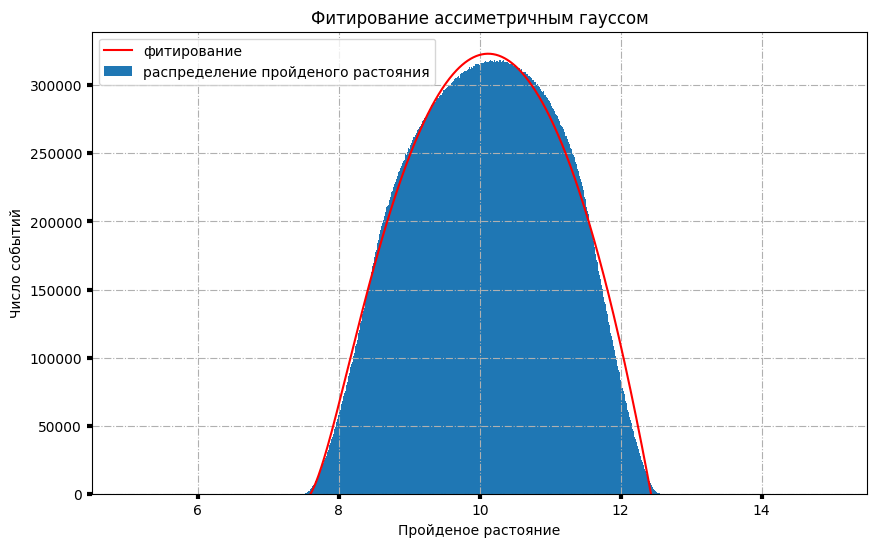

In [12]:
xxx = []
yyy = []
for i in range(i_min, i_max):
    if gauss_as(l[i], args[0], args[1], args[2], args[3], args[4]) > 0:
      xxx.append(l[i])
      yyy.append(gauss_as(l[i], args[0], args[1], args[2], args[3], args[4]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование ассиметричным гауссом')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)


ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")
ax.plot(xxx, yyy, color='r', label = "фитирование")
ax.legend()
pyplot.show()

In [13]:
#Фитирование гаусовым пиком
def gauss_log(x, a, b, c, d):
    return a/x* np.exp(-(np.log(x) + b)**2/c) + d
args, covar = curve_fit(gauss_log, l[i_min:i_max], data[i_min:i_max], [300000.0,-2.1, 1.0, 0.0])
perr = np.sqrt(np.diag(covar))
args, perr

(array([ 6.31186029e+06, -2.33619356e+00,  8.20080651e-02, -2.93341399e+05]),
 array([3.59140692e+05, 3.18325784e-03, 6.53857498e-03, 3.54260622e+04]))

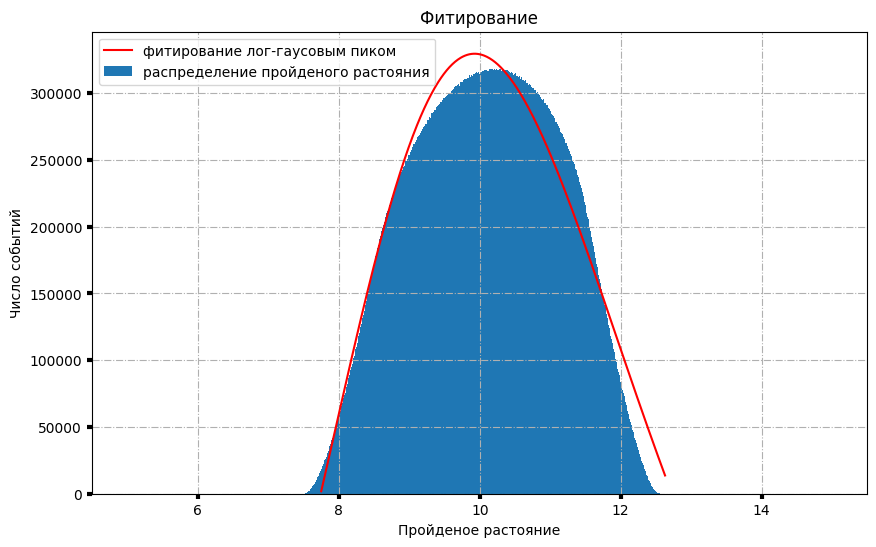

In [14]:
xx = []
yy = []
for i in range(i_min, i_max):
    if gauss_log(l[i], args[0], args[1], args[2], args[3]) > 0:
      xx.append(l[i])
      yy.append(gauss_log(l[i], args[0], args[1], args[2], args[3]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)


ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")
ax.plot(xx, yy, color='r', label = "фитирование лог-гаусовым пиком")
ax.legend()
pyplot.show()

In [92]:
#Фитирование полиномом
def pol_6(x, a, b, c, d, f, g, h):
    return a+b*x+c*x**2+d*x**3+f*x**4+g*x**5+h*x**6
def pol_3(x, a, b, c, d):
    return a+b*x+c*x**2+d*x**3

args_6, covar_6 = curve_fit(pol_6, l[i_min:i_max], data[i_min:i_max], absolute_sigma=True)
perr_6 = np.sqrt(np.diag(covar_6))
print("6: ", args_6, perr_6)
args_3, covar_3 = curve_fit(pol_3, l[i_min:i_max], data[i_min:i_max], absolute_sigma=True)
perr_3 = np.sqrt(np.diag(covar_3))
print("3: ", args_3, perr_3)

6:  [ 1.82134557e+09 -1.12235965e+09  2.86360962e+08 -3.87408279e+07
  2.93223970e+06 -1.17750885e+05  1.95998906e+03] [7.62104725e+03 4.67172807e+03 1.18640007e+03 1.59773064e+02
 1.20349689e+01 4.80801215e-01 7.95968706e-03]
3:  [-3.64524929e+06  5.94031094e+05 -1.51016827e+03 -1.82561513e+03] [16.98791621  5.17522982  0.51946746  0.01718775]


power =  3
 args =  [-3.64522935e+06  5.94024999e+05 -1.50955600e+03 -1.82563537e+03]
 chi sq = 4926831103.271943
  9660453.143670477


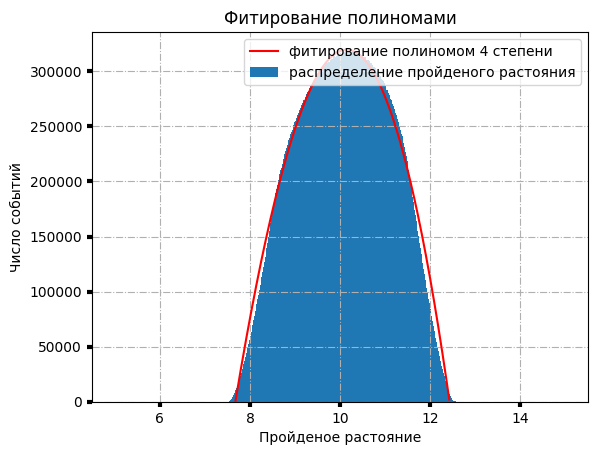

power =  4
 args =  [ 1.96782145e+07 -8.94574898e+06  1.44746041e+06 -9.87021083e+04
  2.40627119e+03]
 chi sq = 1826901895.8894734
  3589198.223751421


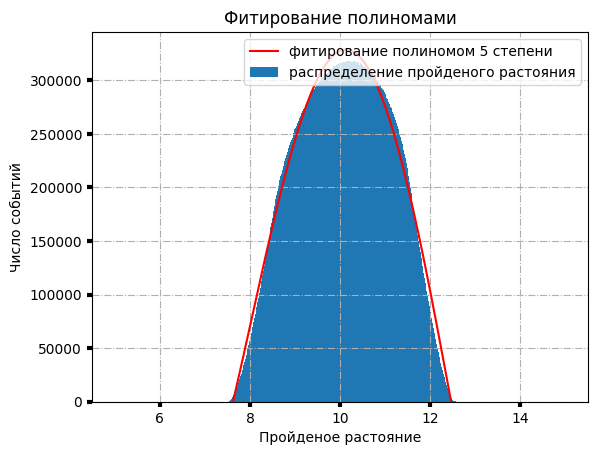

power =  5
 args =  [-3.91026522e+07  2.11406564e+07 -4.66550008e+06  5.17641453e+05
 -2.84353287e+04  6.12848878e+02]
 chi sq = 1187091226.6247714
  2336793.753198369


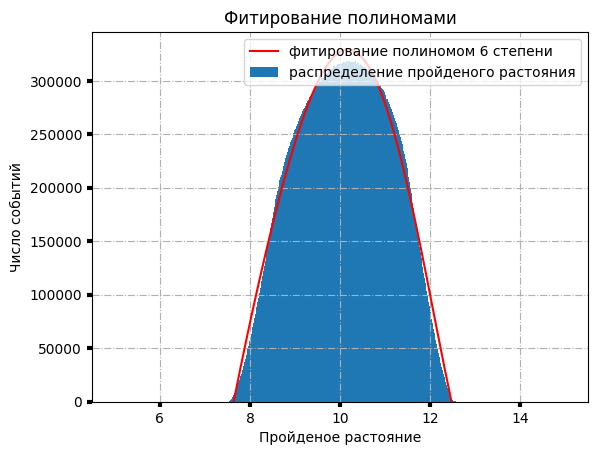

power =  6
 args =  [ 1.82123760e+09 -1.12229386e+09  2.86344361e+08 -3.87386076e+07
  2.93207369e+06 -1.17744305e+05  1.95988101e+03]
 chi sq = 79292552.85462758
  156395.56776060667


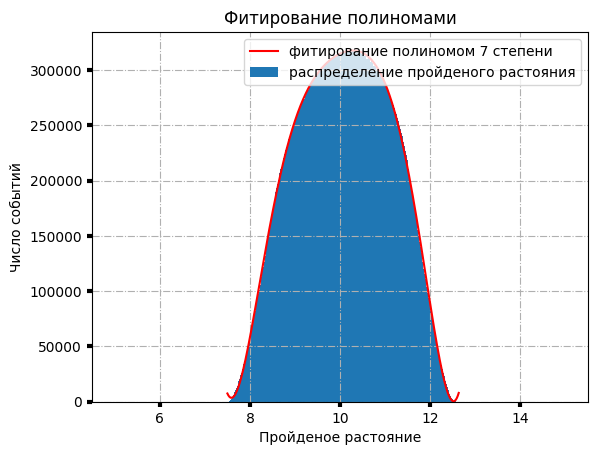

power =  7
 args =  [ 1.61266303e+09 -9.72631806e+08  2.40562794e+08 -3.09991166e+07
  2.15113481e+06 -7.07086698e+04  3.94043900e+02  2.22282126e+01]
 chi sq = 89389143.56017837
  176658.38648256595


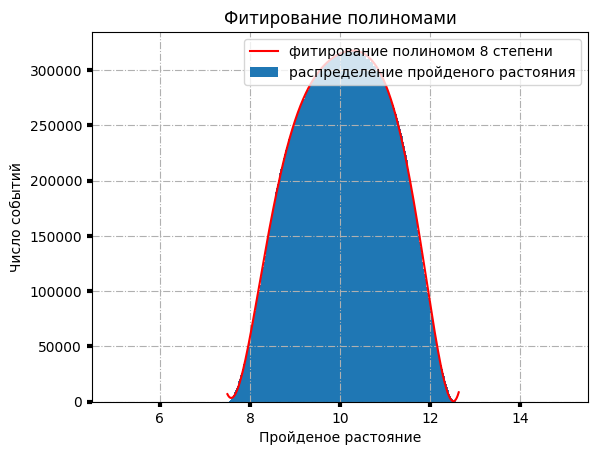

power =  8
 args =  [ 1.23278407e+09 -6.53396009e+08  1.23791428e+08 -6.71632860e+06
 -9.88774088e+05  1.87813832e+05 -1.28418896e+04  4.07515797e+02
 -4.88234025e+00]
 chi sq = 82371700.45265473
  163112.27812406878


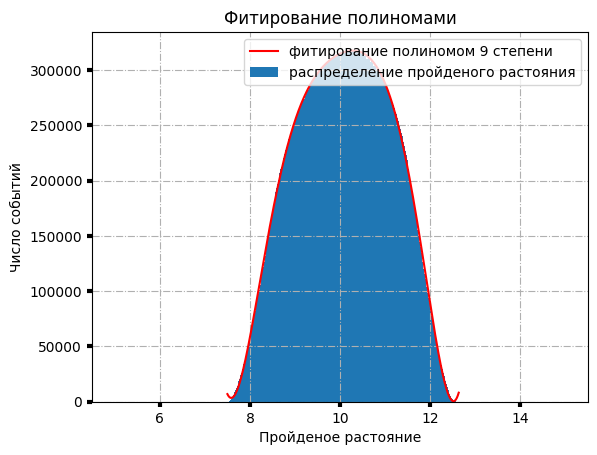

power =  9
 args =  [ 5.01482152e+08 -1.59685300e+08 -1.54726276e+06  4.38781642e+06
  2.31414394e+05 -2.35657101e+05  3.60826333e+04 -2.58976340e+03
  9.25979996e+01 -1.33063777e+00]
 chi sq = 59479076.11048767
  118014.03990176125


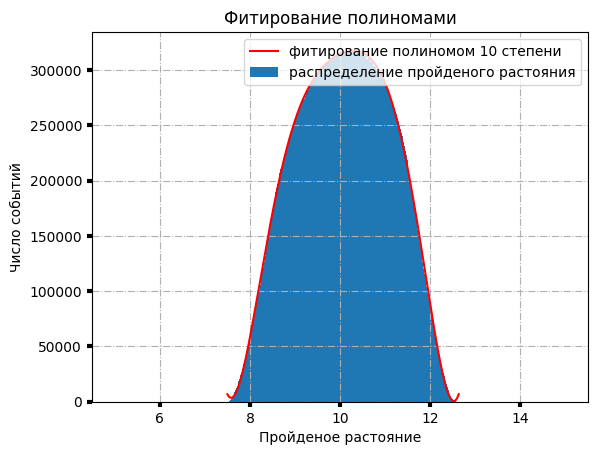

power =  10
 args =  [ 1.02863068e+08 -4.20003213e+06 -3.18273786e+04 -3.94873611e+06
  1.00170093e+06  1.27877134e+04 -3.47337041e+04  5.53858239e+03
 -4.08925283e+02  1.50854347e+01 -2.24943651e-01]
 chi sq = 33677580.494804844
  66953.44034752453


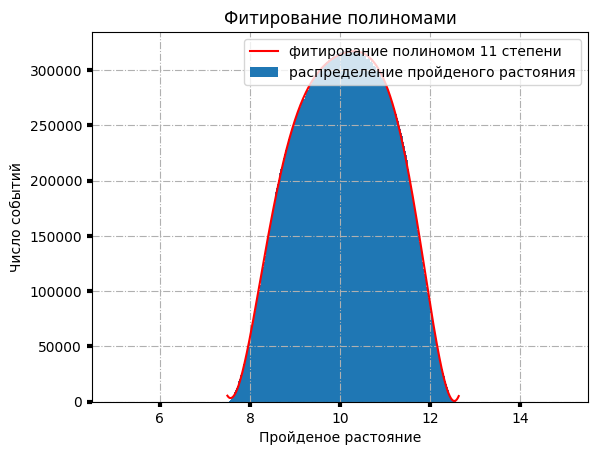

power =  11
 args =  [-4.46876535e+06  2.70077595e+07 -2.63711914e+03 -3.61402634e+06
  6.14283682e+05  3.27513303e+04 -1.35733188e+04  1.30104405e+02
  2.07834363e+02 -2.32424085e+01  1.04125116e+00 -1.75023950e-02]
 chi sq = 16074661.593808495
  32021.238234678276


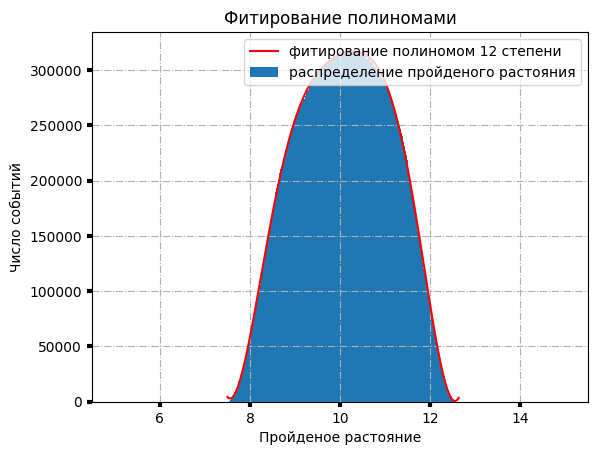

power =  12
 args =  [-1.92948908e+08  8.93632820e+07 -3.57227856e+02 -4.75676502e+06
  2.95614436e+05  1.51507911e+05 -2.48279159e+04  2.93931254e+02
  2.02645577e+02 -1.51089820e+01  6.73167087e-02  2.78889017e-02
 -7.79534700e-04]
 chi sq = 3213425.5479475777
  6414.0230497955645


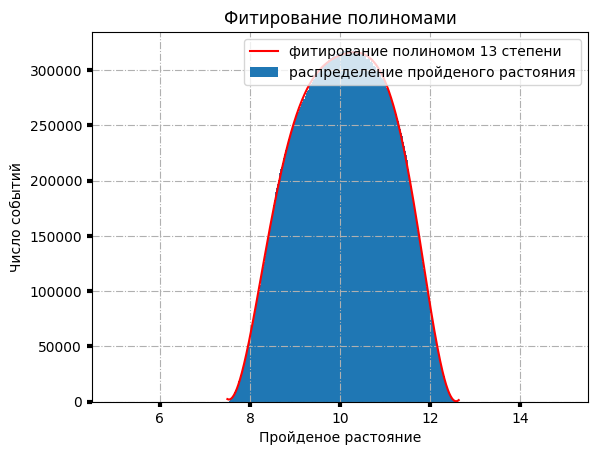

power =  13
 args =  [-2.13970379e+08  1.00103142e+08 -1.78497351e+01 -6.11212708e+06
  7.66578148e+05  7.39423642e+04 -1.86148621e+04  2.50648316e+02
  1.68685883e+02 -1.30677526e+01  1.44745182e-01  1.37406936e-02
 -1.48771145e-04 -9.98434375e-06]
 chi sq = 2741128.411179578
  5482.256822359156


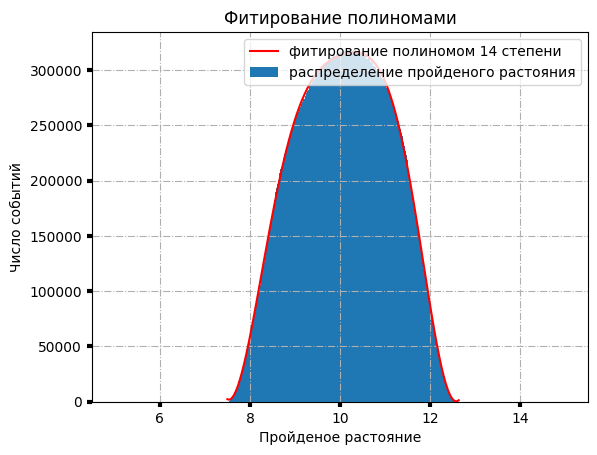

power =  14
 args =  [ 2.40285025e+07  6.93190785e+06 -2.94197817e+01 -1.32376807e+06
  3.44096585e+04  9.73969824e+04 -2.07895776e+04  1.50256068e+03
  2.89049979e+01 -1.02957969e+01  1.11818841e-01  9.48910730e-02
 -9.88090503e-03  4.32501545e-04 -7.35196091e-06]
 chi sq = 1491206.8348613468
  2988.3904506239414


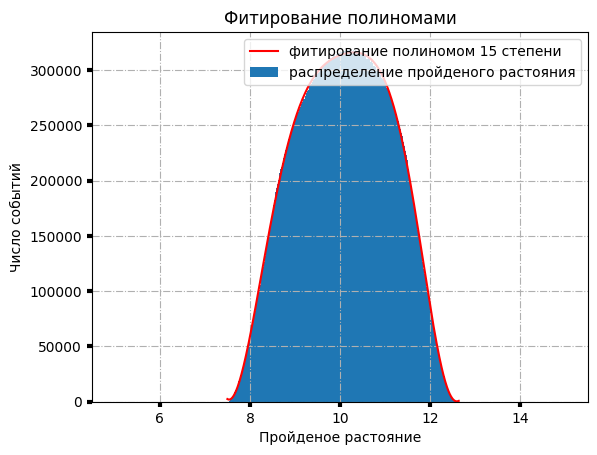

power =  15
 args =  [ 4.87839979e+07  1.00516988e+05  5.42565399e+00 -1.29801106e+06
  9.94011049e+02  1.33864366e+05 -3.05748060e+04  2.51610313e+03
  1.16531705e+01 -1.39073016e+01  1.81333839e-01  1.03185979e-01
 -7.70170628e-03  9.29122911e-05  9.38520294e-06 -2.89955790e-07]
 chi sq = 981604.9400652192
  1971.0942571590747


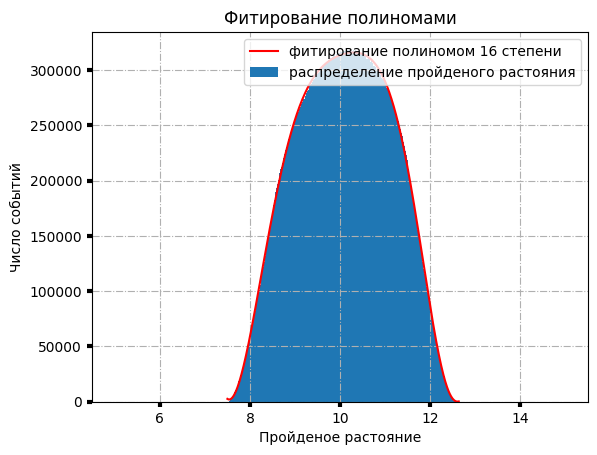

power =  16
 args =  [ 9.87034954e+07  3.17668373e+04  8.44114982e+00 -3.13178989e+06
  3.19191974e+01  3.62488122e+05 -8.56105146e+04  7.15029729e+03
 -2.82304503e-01 -2.86851112e+01  1.15015234e-01  1.08984918e-01
 -5.82766063e-05  8.33344288e-06 -5.86476252e-05  4.31261363e-06
 -9.16719421e-08]
 chi sq = 3779529.1795240985
  7604.686477915691


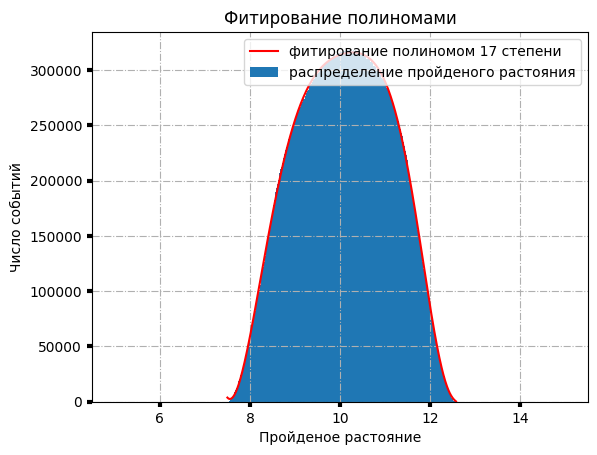

power =  17
 args =  [ 1.09006645e+08  2.67612187e+04  2.34566775e+00 -3.42847385e+06
  5.78401294e+01  3.89182648e+05 -9.03912374e+04  7.37443491e+03
 -2.81415287e-01 -2.72676061e+01  7.64373829e-02  8.97239066e-02
  5.26134532e-05  6.22929023e-05 -2.98140000e-05  9.23188301e-08
  1.19379205e-07 -3.73711736e-09]
 chi sq = 6265577.694038341
  12632.213092819236


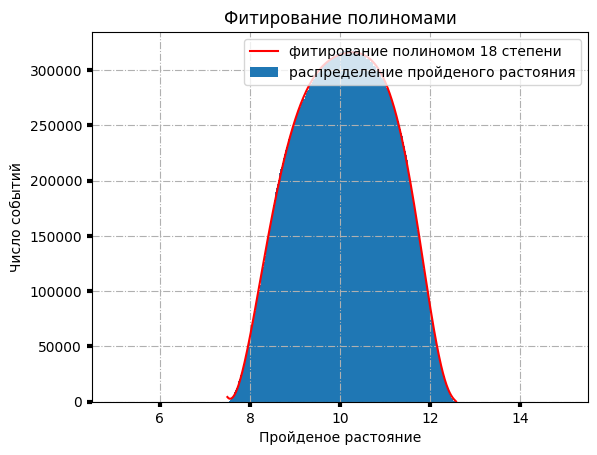

power =  18
 args =  [ 1.19013663e+08  1.73105706e+04  8.48586166e-01 -3.70128705e+06
  6.31009326e+01  4.12455748e+05 -9.44285080e+04  7.56309312e+03
 -1.04784358e+00 -2.65819572e+01  1.32723437e-01  7.43713853e-02
 -2.24115659e-04  7.05787427e-05 -1.41747523e-05 -3.30678543e-07
 -6.26782779e-09  5.90836202e-09 -2.05521776e-10]
 chi sq = 11471481.194346063
  23174.7094835274


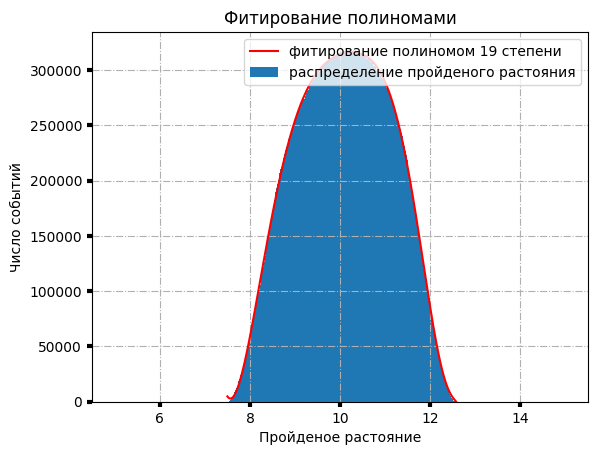

In [100]:
a_zero = args_3
for i_pow in range(4, 20):
    def pol(x, *a):
        s = a[0]
        for i in range(1, i_pow):
            s+=a[i]*(x**i)
        return s
    args, covar = curve_fit(pol, l[i_min:i_max], data[i_min:i_max], a_zero, absolute_sigma=True)

    a_zero = np.append(args, 0.0)

    perr = np.sqrt(np.diag(covar))
    print("power = ", i_pow-1)
    print(" args = ", args)

    chisq=0
    for i in range(i_min, i_max):
        chisq += (data[i] - pol(l[i], *args))**2/ data[i]
    print(" chi sq =",chisq)
    print(" ", chisq/(i_max - i_min - i_pow))

    x = []
    y = []
    for i in range(i_min, i_max):
        if pol(l[i], *args) > 0:
          x.append(l[i])
          y.append(pol(l[i], *args))

    fig, ax = plt.subplots()
    ax.set_title('Фитирование полиномами')
    ax.set_xlabel('Пройденое растояние')
    ax.set_ylabel('Число событий')
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize='medium', width=3)

    ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")
    ax.plot(x, y, color='r', label = "фитирование полиномом "+str(i_pow)+ " степени")
    ax.legend()
    pyplot.show()


In [54]:
# Подсчёт хи квадрата
print("не нулевых бинов=", i_max - i_min)

chisq = 0
for i in range(i_min, i_max):
    r = data[i] - pol_6(l[i], *args_6)
    chisq += r**2/ data[i]
print("chisq =",chisq)
print(chisq/(i_max - i_min - 7))

не нулевых бинов= 514
chisq_pol = [27479865.243690975, 12453583.43118478, 491789.59608837334, 1689779.2580599512, 3018947.764803622, 5662141.630771796, 19163181.79520741, 40864265.67369165, 39544812.105246946]
[54631.93885425641, 24807.93512188203, 981.6159602562342, 3379.5585161199024, 6049.995520648541, 11369.76231078674, 38557.70984951189, 82387.6324066364, 79888.50930352918]
chisq = 79324643.8392642
156458.8635882923


111
<!-- ### Определение зависимости от параметров
Проделаем серию вычислений, для разных значений параметров задачи: $a, R, H, L, θ$

Для простоты фитирование вынесено в отдельный файл. -->